![Image](./resources/cropped-SummerWorkshop_Header.png)

<h1 align="center">Population Coding: Part 1</h1> 
<h2 align="center"> Day 2, Morning Session</h2> 

<h3 align="center">Tuesday, August 22, 2023</h3> 

<br>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<h2> The Questions </h2>
    
<p> The first week of the course is devoted to question focused workshops and addresing those questions with datasets and computational methods that we will present.  Each day will be devoted to its own question:  
    

<li> Day 1:  How do single neurons encode information about the external world?  
<b><li> Day 2:  How do populations of neurons encode information about the external world? </b>
<li> Day 3:  How do cell type and circuit architecture contribute to physiological function?
<li> Day 4:  What is a behavioral state and how can we define it? 
<li> Day 5:  How does network structure lead to network dynamics?

## Introduction

In yesterday's lesson, we learned how to compute tuning curves for individual neurons, to better understand how they encode information about the environment (specifically the direction of a drifting grating stimulus). Today, we will expand our focus to **how information is encoded in *neural populations***. Understanding how populations of neurons create models of the world that are used to guide behavior is a central goal of systems neuroscience. In this tutorial, we will learn techniques for computing the information that can be read out of population activity *in principle*, which can be used to contrain hypotheses about how the brain uses this information in practice.

We will also introduce a **new dataset**, the Allen Brain Observatory Visual Coding Neuropixels. This dataset, which was released in 2019, is similar to the 2P dataset covered yesterday, but includes electrophysiological recordings of spike times instead of calcium-dependent fluorescence traces. This dataset is ideal for studying population coding because it includes simultaneous recordings from many brain regions in mice passively viewing a wide range of visual stimuli.

In addition, we will build upon yesterday's lesson by using `scikit-learn` to perform **classification** instead of regression. The techniques for building design matrices and fitting model will be re-used in this tutorial.  

## Dataset overview

The **Allen Brain Observatory Visual Coding Neuropixels** pipeline was designed with a number of goals in mind:
- Conduct *in vivo* electrophysiology experiments in a higher throughput, more standardized manner than was possible previously
- Reproduce the same stimuli from the 2P observatory, in order to allow a direct comparison of imaging and electrophysiology data
- Record activity simultaneously in multiple brain regions, including sub-cortical areas such as hippocampus and thalamus

The rigs for this pipeline were designed to as similar as possible to the 2P rigs from the mouse's perspective; we've just replaced the imaging objective (left) with an array of six Neuropixels probes (right):

![Ophys vs. ephys rig comparison](./resources/ophys_vs_ephys_rig_comparison.png)

Electrophysiology (or "ephys") has a number of important differences to 2P imaging that must be considered when deciding which type of data is best suited for your scientific question:
- **Temporal resolution:** Ephys samples extracellular voltages around 30,000 times per second, making it possible to detect voltage deflections that correspond to action potentials ("spikes"). 2P imaging samples calcium-dependent fluorescence changes at around 30 times per second, making it difficult to resolve single spikes.
- **Spatial configuration:** Neuropixels probes sample voltages along a straight line that can extend into deep structures, all the way down to the bottom of the brain. 2P imaging is limited to sampling a plane up to a few hundred microns below the surface, unless a large lens is implanted in the brain.
- **Cell type specificity:** Ephys can label one genetically defined cell type per experiment through optotagging, but most of the recorded cells have unknown cell type identities. By expressing calcium indicators in a genetically defined sub-population, 2P imaging ensures that *all* the recorded cells are from the same class.
- **Chronic vs. acute:** Current techniques greatly limit the number of neurons that can be recorded chronically over many days in a mouse brain, relative to preparations in which electrodes are inserted and removed each day. 2P imaging, on the other hand, makes it possible to return to the same field of view over many weeks.

Here is a side-by-side comparison of 2P imaging (left) and Neuropixels (right) data from 50 simultaneously recorded neurons in Visual Cortex. Note that the 2P data consists of continuous dF/F traces that vary in size over several orders of magnitude, while the Neuropixels data consists of discrete spike times:

![Ophys vs. ephys data comparison](./resources/ophys_vs_ephys_data_comparison.png)

For this tutorial, we've chosen to use the Neuropixels dataset, but similar techniques could be applied to 2P imaging data as well.

## Tutorial goals

We will first introduce the Allen Brain Observatory Neuropixels dataset, and use it to read out information about stimulus identity from neural populations. We will focus on activity in primary visual cortex (Allen CCF acronym: `VISp`) and drifting gratings stimuli, but the methods will generalize to other areas and stimulus types.

We will explore how populations of neurons encode information by attempting to use a classifier to *decode* drifting grating orientation from simultaneously recorded spike trains. This involves training different classifiers to identify the stimulus parameters on held-out trials. We will use two types of classifiers, Support Vector Machines and Random Forests, but almost any [`scikit-learn` classifier](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) could be substituted instead.

Let's start by importing some of the packages we'll need:

In [21]:
import numpy as np    # used for creating and manipulating arrays

import matplotlib.pyplot as plt  # used for plotting data
%matplotlib inline

And setting the path to the data, depending on where we're running the code:

In [22]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

### Exploring the Neuropixels Visual Coding dataset

The Allen Brain Observatory Neuropixels Visual Coding dataset consists of 58 passive viewing sessions that use many of the same stimuli as the 2P Visual Coding experiments we learned about yesterday.

We will access the data via the AllenSDK. The gateway to the data is through an `EcephysProjectCache` object. If you're analyzing data on a local machine, this object will keep track of which files you have downloaded, and retrieve additional files as needed. In this case, we're doing our analysis in the cloud, and the public S3 bucket containing all of the data files is already mounted. So we just need to make sure the `EcephysProjectCache` object is aware of the location where the data is stored:

In [23]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

manifest_path = os.path.join(data_root,'allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json') 

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path) # cache is a class object that contains all the data from the manifest file 

We can use the `cache` object to retrieve a table containing information about all of the experimental sessions:

In [26]:
sessions = cache.get_session_table() #this will load the session table as a pandas dataframe with unique session_id as index, and a number of metadata columns

#get total number of sessions  
print('Total number of sessions: ' + str(len(sessions)))

sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


Each session is indexed by a unique `id`, and has other columns with information about the subject, session type, etc.

We can examine at a single row to see what information is available about each session:

In [27]:
sessions.iloc[0] #first session in the table

published_at                                               2019-10-03T00:00:00Z
specimen_id                                                           699733581
session_type                                              brain_observatory_1.1
age_in_days                                                               118.0
sex                                                                           M
full_genotype                     Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
unit_count                                                                  884
channel_count                                                              2219
probe_count                                                                   6
ecephys_structure_acronyms    [CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ...
Name: 715093703, dtype: object

We have information about the subject (e.g. age, sex, genotype), as well as the total number of units recorded, and a list of structures they were recorded from. We use the term "units" instead of "neurons" because each unit may actually include spikes from multiple nearby neurons. The units that are returned by default are pre-filtered to remove those with high levels of contamination (based on the `isi_violations` metric), but they are  not guaranteed to all correspond to perfectly isolated neurons.

We can filter this table to find, for example, the sessions carried out in Sst-IRES-Cre mice, which are used to optotag somatostatin-positive interneurons.  We'll use the Pandas [`map`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) method to apply the same function to every element in a column. In this case, the method must return either `True` or `False` to indicate whether a particular row is of interest:

In [39]:
def check_genotype(genotype):
    return 'Sst' in genotype

#apply the check_genotype function to the full_genotype column of the sessions table
sessions_Sst = sessions[sessions['full_genotype'].map(check_genotype)]

#print the length of the sessions_Sst table
print('Number of sessions with Sst: ' + str(len(sessions_Sst)))

sessions_Sst.head()

Number of sessions with Sst: 12


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."
758798717,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,593,1486,4,"[MGv, MGd, TH, DG, CA1, VISal, nan, SGN, LP, S..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
<b>Task:</b> How would you use this table to find all of the sessions that include recordings from a particular brain region (e.g. <tt>VISp</tt>)?
</div>

In [41]:
def check_for_region(region):
    return 'VISp' in region #check if VISp is in the region column

sessions_Sst_Visp = sessions_Sst[sessions_Sst['ecephys_structure_acronyms'].map(check_for_region)]

#print the number of sessions in VISp with Sst
print('Number of sessions with Sst in VISp: ' + str(len(sessions_Sst_Visp)))

sessions_Sst_Visp.head()

Number of sessions with Sst in VISp: 12


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."
758798717,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,593,1486,4,"[MGv, MGd, TH, DG, CA1, VISal, nan, SGN, LP, S..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"


One of the most important things to consider about each session is the `session_type`, of which there are two in the Neuropixels Visual Coding dataset. We can use the Pandas [`unique`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html) method to find the unique values in the `session_type` column:

In [42]:
sessions.session_type.unique()

array(['brain_observatory_1.1', 'functional_connectivity'], dtype=object)

The two session types differ in the visual stimuli that were used. `brain_observatory_1.1` sessions include many stimuli that are identical to the ones shown in the 2P Visual Coding experiments, to facilitate direct comparisons between these two data modalities. `functional_connectivity` sessions use similar stimuli but with fewer conditions and more repeats, to facilitate analysis of cross-area interactions. 

A timeline of each session type is available in the Neuropixels Cheat Sheet PDF, and is also reproduced here:

![Diagram of stimuli for each session type](./resources/neuropixels_visual_stimuli-2.png)

For this tutorial, we are going to use the "Brain Observatory 1.1" sessions, which include the identical drifting grating stimulus as the 2P experiments.

Every unit that was recorded has some pre-computed functional metrics based on its response to each stimulus type, which can be accessed as a `DataFrame` via the `cache` object:

In [47]:
unit_metrics = cache.get_unit_analysis_metrics_by_session_type('brain_observatory_1.1') #get the unit metrics for the brain_observatory_1.1 sessions 

len(unit_metrics)

#print the number of units in the unit_metrics table
print('Number of units: ' + str(len(unit_metrics)), '\n' + 'Number of columns: ' + str(len(unit_metrics.columns))) 

unit_metrics.head()

Number of units: 21842 
Number of columns: 102


,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cumulative_drift,d_prime,waveform_duration,ecephys_channel_id,firing_rate,waveform_halfwidth,isi_violations,...,pref_ori_multi_dg,pref_ori_multi_sg,pref_phase_multi_sg,image_selectivity_ns,pref_images_multi_ns,lifetime_sparseness_dg,lifetime_sparseness_fl,lifetime_sparseness_ns,lifetime_sparseness_rf,lifetime_sparseness_sg
ecephys_unit_id,,,,,,,,,,,,,,,,,,,,,
915956282,0.611816,164.878740,0.072728,309.71,3.910873,0.535678,850229419,6.519432,0.164824,0.104910,...,False,False,False,0.286831,False,0.209965,0.563430,0.070184,0.555840,0.094790
915956340,0.439372,247.254345,0.000881,160.24,5.519024,0.563149,850229419,9.660554,0.206030,0.006825,...,False,False,False,0.275932,False,0.062212,0.034415,0.067967,0.180490,0.054469
915956345,0.500520,251.275830,0.001703,129.36,3.559911,0.521943,850229419,12.698430,0.192295,0.044936,...,False,False,False,0.179102,False,0.086342,0.337854,0.045184,0.302351,0.062177
915956349,0.424620,177.115380,0.096378,169.29,2.973959,0.508208,850229419,16.192413,0.192295,0.120715,...,False,False,False,0.323068,False,0.095038,0.166625,0.028184,0.073108,0.029319
915956356,0.512847,214.954545,0.054706,263.01,2.936851,0.549414,850229419,2.193113,0.233501,0.430427,...,False,False,False,-0.046051,False,0.114104,0.241255,0.056767,0.416234,0.067618


To find the metrics computed based on responses to the drifting gratings (`dg`) stimulus, we can search for all the metric names with `dg` appended:

In [45]:
dg_metrics = [column_name for column_name in unit_metrics.columns if 'dg' in column_name] #get the names of the columns that contain 'dg' in their name
dg_metrics

['c50_dg',
 'fano_dg',
 'f1_f0_dg',
 'g_dsi_dg',
 'g_osi_dg',
 'mod_idx_dg',
 'pref_tf_dg',
 'run_mod_dg',
 'pref_ori_dg',
 'run_pval_dg',
 'firing_rate_dg',
 'pref_tf_multi_dg',
 'pref_ori_multi_dg',
 'lifetime_sparseness_dg']

There are 14 different metrics for the drifting gratings (`dg`) stimulus type, which have been computed for all units in this dataset. Later, we'll use the `g_dsi_dg` metric to find units in V1 that are most selective for grating direction. `g_dsi` is the acronym for "global direction selectivity index," which is a measure of how much a neuron is tuned to a single grating direction (this is related to how informative its spikes will be about the particular grating being presented).

Let's filter the `unit_metrics` `DataFrame` to select a session that has a reasonably large number of units in V1:

In [49]:
# get the IDs for all sessions with units in VISp
session_ids = unit_metrics[unit_metrics.ecephys_structure_acronym == 'VISp'].ecephys_session_id.values #find all the units in VISp, and get the session IDs for those units

# find the unique session IDs, and count how many there are of each
unique_sessions, counts = np.unique(session_ids, return_counts=True) #return_counts=True returns the number of times each unique item appears in the array
order = np.argsort(counts) #sort the counts array and return the indices that would sort the array 

print('Unique session IDs:')
print(unique_sessions[order])
print(' ')
print('Count of units in V1:')
print(counts[order])

Unique session IDs:
[746083955 739448407 742951821 744228101 761418226 773418906 737581020
 721123822 743475441 758798717 751348571 756029989 750749662 719161530
 759883607 715093703 750332458 760345702 763673393 762602078 755434585
 799864342 757970808 762120172 757216464 797828357 760693773 754829445
 791319847 798911424 754312389 732592105]
 
Count of units in V1:
[ 14  19  33  35  36  37  40  41  45  47  49  51  52  52  58  60  63  72
  73  75  75  75  80  84  85  85  88  92  93  94 102 110]


Let's analyze session `798911424`, which has 94 V1 units. Note that these unit counts are generated *after* default quality control metrics are applied, so we can be reasonably confident that these units were recorded throughout the whole session and are free of contamination. For more information about unit quality metrics and how to use them, please see [this tutorial](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html).

### Loading data for one session

We can load the data for this session based on the unique session ID:

In [51]:
session_id = 798911424 #this session has 94 sessions in VISp so it will be better for decoding purposes

session = cache.get_session_data(session_id)

The `session` object we just created will serve as the interface to all of the data for this experiment, including the spike times, stimulus info, and behavioral data (e.g. running speed).

First, we'll load a table of units for this session. Note that this step can sometimes be slow, since all of the spike times need to be loaded into memory.

In [52]:
units = session.units # can be slow -- needs to load all spike times

units.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951088679,0.620607,82.147455,0.023654,1,480.97,2.575648,7.429131,0.053350,51.364291,0.028062,...,215.0,APN,8328,3018,7095,probeA,See electrode locations,29999.965974,1249.998582,True
951088664,0.587044,78.399165,0.001739,0,427.07,3.085334,6.843864,0.033732,40.358293,0.051513,...,215.0,APN,8328,3018,7095,probeA,See electrode locations,29999.965974,1249.998582,True
951088734,0.560996,187.504005,0.001249,5,311.01,5.152564,1.418476,0.356931,56.950961,0.001292,...,215.0,APN,8316,2988,7099,probeA,See electrode locations,29999.965974,1249.998582,True
951088721,0.474457,196.741545,0.000059,4,355.17,4.295014,11.517381,0.000271,58.358552,0.020218,...,215.0,APN,8316,2988,7099,probeA,See electrode locations,29999.965974,1249.998582,True
951088862,0.534674,92.125020,0.089901,16,239.50,4.043348,19.953126,0.013619,79.934237,0.011335,...,215.0,APN,8304,2958,7103,probeA,See electrode locations,29999.965974,1249.998582,True


The units table contains important information about each unit that was recorded, including its spike sorting quality metrics, its 3D position in the Allen Common Coordinate Framework, and the structure in which it's located. 

Here is a brief summary of the columns in this table:

|column name | description |
|------------|-------------|
|`unit_id` | the identifier for this unit assigned by the AllenSDK (unique across the entire dataset)|
|`waveform_PT_ratio`| peak-to-trough ratio of the average spike waveform |
|`waveform_amplitude`| amplitude (in microvolts) of the average spike waveform |
|`amplitude_cutoff`| a measure of the approximate fraction of spikes missing from this unit (default threshold = 0.1)|
|`cluster_id` | the identifier for this unit assigned by the spike sorting algorithm (unique within each probe)|
|`cumulative_drift` | the integrated distance (in microns) that the unit drifted across the whole session |
|`d_prime` | a measure of how separable this unit's waveforms are from its neighbors' |
|`firing_rate` | mean spike rate across the whole session |
|`isi_violations` | a measure of this unit's level of contamination (default threshold = 0.5) |
|`isolation_distance` | a measure of how separable this unit's waveforms are from its neighbors' (higher is better) |
|`L_ratio` | a measure of how separable this unit's waveforms are from its neighbors' (lower is better) |
|`local_index` | the index of this unit within the probe it was recorded with |
|`max_drift` | the maximum distance (in microns) the unit drifted across the whole session |
|`nn_hit_rate` | a measure of this unit's level of contamination |
|`nn_miss_rate` | a measure of the fraction of spike missing from this unit |
|`peak_channel_id` | the identifier for this unit's peak channel (can be used as an index into the `session.channels` table |
|`presence_ratio` | the fraction of the session over which this unit had spikes detected (default threshold = 0.9) |
|`waveform_recovery_slope` | slope of the waveform between the trough and the peak |
|`waveform_repolarization_slope` | slope of the waveform back to 0 after the peak |
|`silhouette_score` | a measure of this unit's level of contamination |
|`snr` | the ratio of the waveform amplitude relative to the background noise on the peak channel |
|`waveform_spread` | distance the waveform extends above and below the peak channel |
|`waveform_velocity_above` | speed of waveform propagation above the peak channel |
|`waveform_velocity_below` | speed of waveform propagation below the peak channel |
|`waveform_duration` | time between the waveform peak and trough |
|`filtering` | filter properties of the probe used to record this unit |
|`probe_channel_number` | local index of this unit's peak channel |
|`probe_horizontal_position` | horizontal position of this unit on the probe |
|`probe_id` | identifier of the probe used to record this unit |
|`probe_vertical_position` | vertical position of this unit on the probe |
|`structure_acronym` | CCF region where this unit is located |
|`ecephys_structure_id` | CCF structure ID where this unit is located |
|`ecephys_structure_acronym` | alias for `structure_acronym` |
|`anterior_posterior_ccf_coordinate` | CCF coordinate along the A/P axis |
|`dorsal_ventral_ccf_coordinate` | CCF coordinate along the D/V axis |
|`left_right_ccf_coordinate` | CCF coordinate along the L/R axis |
|`probe_description` | name of the probe used to record this unit |
|`location` | not used |
|`probe_sampling_rate` | spike band sampling rate of the probe used to record this unit |
|`probe_lfp_sampling_rate` | LFP band sampling rate of the probe used to record this unit |
|`probe_has_lfp_data` | `True` if LFP data was recorded on the same probe |


The primary data we'd like to analyze for unit is its spike train. Spike times for each unit are contained in the `spike_times` dictionary of the `session` object, and are accessed by `unit_id`:

In [54]:
session.spike_times[units.index.values[0]] #returns the spike times for the first unit
session.mean_waveforms[units.index.values[0]] #mean waveform for the first unit 

<xarray.DataArray (channel_id: 374, time: 82)>
array([[ 0.000000e+00,  1.988025e+00, -2.610660e+00, ..., -1.270425e+00,
        -2.568150e+00, -1.753635e+00],
       [ 0.000000e+00, -4.169100e-01, -3.082950e-01, ..., -1.934400e-01,
        -8.942700e-01, -4.026750e-01],
       [ 0.000000e+00,  1.753050e-01,  5.411250e-01, ..., -7.176000e-02,
        -8.320650e-01, -1.562145e+00],
       ...,
       [ 0.000000e+00,  3.935100e-01,  2.219100e-01, ...,  3.047850e-01,
        -3.763500e-01, -4.243200e-01],
       [ 0.000000e+00, -1.817400e-01, -2.889900e-01, ..., -7.427550e-01,
        -6.823050e-01, -1.209390e+00],
       [ 0.000000e+00,  1.950000e-04,  6.357000e-01, ..., -1.612650e-01,
        -5.339100e-01,  3.476850e-01]])
Coordinates:
  * channel_id  (channel_id) int64 849855456 849855458 ... 849856220 849856222
  * time        (time) float64 0.0 3.333e-05 6.667e-05 ... 0.002667 0.0027

We can plot a raster of spike times by looping through all the units in this session:

Text(0, 0.5, 'Unit index')

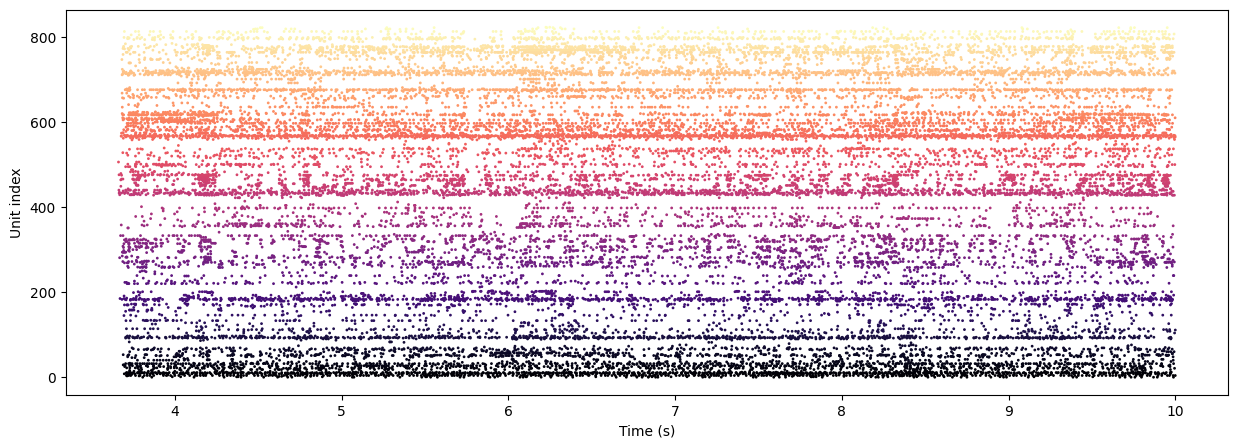

In [53]:
times = [] # list of spike times for all units
unit_indices = [] # list of unit indices for all units

for unit_idx, unit_id in enumerate(units.index.values): # loop over units in session
    spike_times = session.spike_times[unit_id] # get spike times for this unit
    in_range = np.where(spike_times < 10)[0] # find spikes in first 10 seconds 
    times.append(spike_times[in_range]) # add to list of all spike times
    unit_indices.append([unit_idx] * len(in_range)) #  add to list of unit indices
    
plt.figure(figsize=(15,5))
plt.scatter(np.concatenate(times), # concatenate all spike times into one array
            np.concatenate(unit_indices), # concatenate all unit indices into one array
            s=1, # make the dots smaller
            c=np.concatenate(unit_indices), # color the dots by unit index
            cmap='magma') # use the 'magma' colormap
plt.xlabel("Time (s)") # label the x axis
plt.ylabel("Unit index") # label the y axis

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
<b>Task:</b> Plot a spike raster from 1000 to 1010 seconds, for just the cells in primary visual cortex.
</div>

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951102411,1.531084,65.353860,0.015360,220,740.36,5.100031,3.450567,0.096509,93.579076,0.000090,...,385.0,VISp,8849,1588,8189,probeC,See electrode locations,29999.996048,1249.999835,True
951102534,0.410674,49.942425,0.070192,229,286.56,3.032074,2.225140,0.304601,53.847135,0.010158,...,385.0,VISp,8862,1552,8192,probeC,See electrode locations,29999.996048,1249.999835,True
951102476,0.353644,65.311545,0.001183,225,167.67,4.431302,3.241523,0.044427,79.660436,0.002895,...,385.0,VISp,8862,1552,8192,probeC,See electrode locations,29999.996048,1249.999835,True
951102555,0.588960,60.708180,0.017197,231,158.64,3.438301,4.246793,0.117470,71.214613,0.008223,...,385.0,VISp,8865,1543,8193,probeC,See electrode locations,29999.996048,1249.999835,True
951102623,0.513677,62.576670,0.062090,237,196.08,4.499449,2.897875,0.320700,57.162008,0.007504,...,385.0,VISp,8875,1516,8195,probeC,See electrode locations,29999.996048,1249.999835,True


Number of units in VISp: 94


IndexError: single positional indexer is out-of-bounds

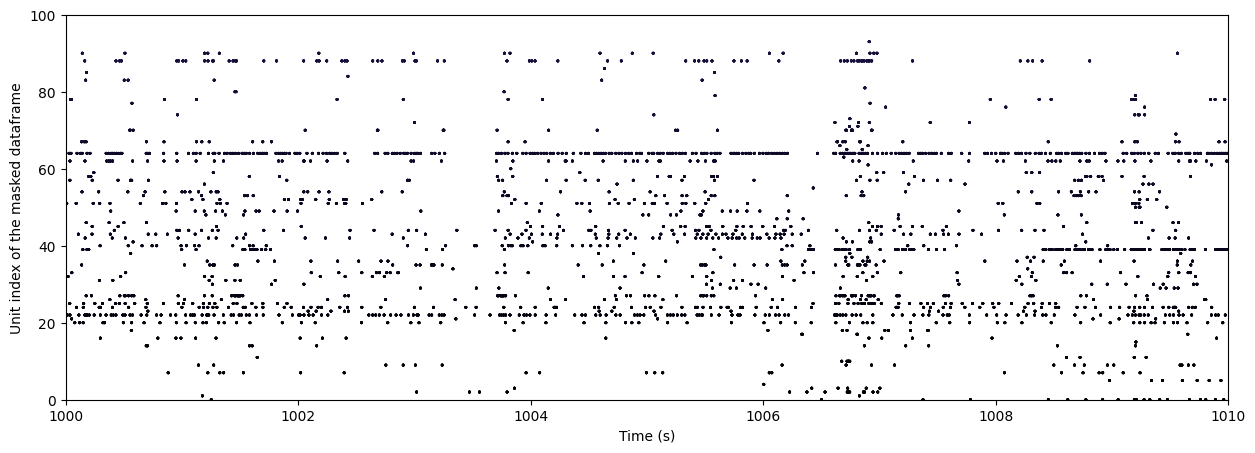

In [67]:
# code goes here
# hint: copy and paste the code from the previous cell, and edit as needed

#create a mask to access units based on the the columns 'ecephys_structure_acronym'
mask = units['ecephys_structure_acronym'] == 'VISp'

#apply the mask to the units table
units_Visp = units[mask]

print('Number of units in VISp: ' + str(len(units_Visp)))


for unit_idx, unit_id in enumerate(units_Visp.index.values):
    spike_times = session.spike_times[unit_id] # get spike times for this unit
    
    #find spikes in 1000s to 1010s
    in_range2 = np.where((spike_times > 1000) & (spike_times < 1010))[0] #find the spikes in the range of 1000s to 1010s  
    
    times.append(spike_times[in_range2]) # add to list of all spike times
    unit_indices.append([unit_idx] * len(in_range2)) #  add to list of unit indices
    
plt.figure(figsize=(15,5))
plt.scatter(np.concatenate(times), # concatenate all spike times into one array
            np.concatenate(unit_indices), # concatenate all unit indices into one array
            s=1, # make the dots smaller
            c=np.concatenate(unit_indices), # color the dots by unit index
            cmap='magma') # use the 'magma' colormap

plt.xlabel("Time (s)") # label the x axis
plt.ylabel("Unit index of the masked dataframe") # label the y axis 

#only plot the 1000s to 1010s range 
plt.xlim(1000,1010)
plt.ylim(0,100)

for unit_idx, unit_id in enumerate(units_Visp.index.values):
    if units.iloc[unit_id].ephys_structure_acronym == 'VISp': #check if the unit is in VISp 
        spike_times = session.spike_times[unit_id] # get spike times for this unit
    
        #find spikes in 1000s to 1010s
        in_range3 = np.where((spike_times > 1000) & (spike_times < 1010))[0] #find the spikes in the range of 1000s to 1010s, the interesection between the two ranges
    
        times.append(spike_times[in_range3]) # add to list of all spike times
        unit_indices.append([unit_idx] * len(in_range3)) #  add to list of unit indices
    
plt.figure(figsize=(15,5))
plt.scatter(np.concatenate(times), # concatenate all spike times into one array
            np.concatenate(unit_indices), # concatenate all unit indices into one array
            s=1, # make the dots smaller
            c=np.concatenate(unit_indices), # color the dots by unit index
            cmap='magma') # use the 'magma' colormap

plt.xlabel("Time (s)") # label the x axis
plt.ylabel("Unit index of the masked dataframe") # label the y axis 

#only plot the 1000s to 1010s range 
plt.xlim(1000,1010)
plt.ylim(0,100)


Next, we'll load a table of containing information about all of the stimuli that were shown. 

**Note:** Before we do this, we need to replace one of the functions in the AllenSDK with a function that returns its input unchanged. This is due to a discrepancy between the NWB files contained in the AWS bucket and what is expected by the latest version of the AllenSDK. This patch is not normally be needed, but it's helpful to understand in case you encounter this issue in the future.

In [68]:
from allensdk.brain_observatory.ecephys.stimulus_table import naming_utilities

def passthrough_function(input):
    return input

naming_utilities.standardize_movie_numbers = passthrough_function
session.naming_utilities = naming_utilities # this is needed to circumvent a bug in the AllenSDK

Now we can load the stimulus presentations table without errors:

In [69]:
stimulus_presentations = session.stimulus_presentations

stimulus_presentations.head()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,24.875987,null,spontaneous,84.942787,null,null,null,60.066800,0
1,null,0.8,null,90.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.942787,0.0,gabors,85.176306,4.0,20.0,-10.0,0.233519,1
2,null,0.8,null,0.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.176306,0.0,gabors,85.426505,4.0,30.0,40.0,0.250199,2
3,null,0.8,null,45.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.426505,0.0,gabors,85.676704,4.0,40.0,-30.0,0.250199,3
4,null,0.8,null,90.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.676704,0.0,gabors,85.926904,4.0,0.0,-40.0,0.250199,4


`stimulus_presentations` is a `DataFrame` containing one row for each presentation or "trial." We can see all of the types of stimuli by looking for the unique stimulus names in this table:

In [ ]:
stimulus_presentations.stimulus_name.unique()

### Plotting one unit's response to drifting gratings

Let's create smaller tables containing only the `drifting_gratings` stimuli, and just the units in V1: 

In [70]:
#make a subset of the stimulus_presentations table that only contains the drifting gratings stimulus
stimulus_presentations_dg = stimulus_presentations[stimulus_presentations.stimulus_name == 'drifting_gratings']

#make a subset of the units table that only contains the units in VISp
units_VISp = units[units.ecephys_structure_acronym == 'VISp']

#make a subset of the unit_metrics table that only contains the units in VISp table 
unit_metrics_VISp = unit_metrics.loc[units_VISp.index.values]

To explore some example drifting grating responses with spikes, we'll select the unit with the highest direction selectivity. When describing gratings stimuli, "direction" refers to the *angle of motion*, which varies between 0 and 360 degrees, while "orientation" refers to the *angle of the grating on individual frames*, which varies between 0 and 180 degrees.

In [71]:
unit_id = unit_metrics_VISp.g_dsi_dg.idxmax() # index of the row with the maximum value

unit_metrics_VISp.loc[unit_id].g_dsi_dg

0.6677837744443985

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
    <b>Task:</b> Plot direction selectivity (<tt>g_dsi_dg</tt>) versus orientation selectivity (<tt>g_osi_dg</tt>) for all units in <tt>VISp</tt>.
</div>

Text(0, 0.5, 'g_osi_dg')

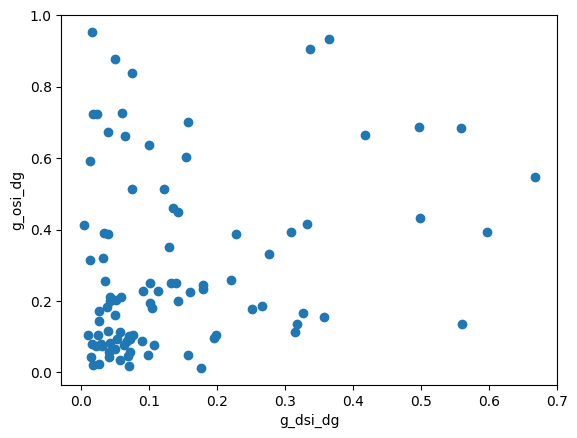

In [73]:
# code goes here
plt.scatter(unit_metrics_VISp.g_dsi_dg, unit_metrics_VISp.g_osi_dg) 

plt.xlabel('g_dsi_dg')
plt.ylabel('g_osi_dg')


Let's plot this unit's response to all of the different drifting gratings stimulus conditions, which include changes in both. Note that the stimulus presentations table only contains one column to describe the grating angle, which is called `orientation`. We need to pre-process this column a bit to find all of the unique values:

In [74]:
# use pandas to find the unique orientation values:
unique_orientations = stimulus_presentations_dg.orientation.unique() #find the unique values in the orientation column of the stimulus_presentations_dg table
print(unique_orientations) #this should be the direction of the drifting grating stimulus 

# remove the null value at the end (indicates blank stimulus):
unique_orientations_without_null = unique_orientations[:-1] 
print(unique_orientations_without_null)

# convert to float values so we can sort them:
unique_orientations_as_float = unique_orientations_without_null.astype('float') #convert the unique_orientations_without_null array to float values because they are stored as a python object
print(unique_orientations_as_float)

# perform the sorting:
orientations = np.sort(unique_orientations_as_float)  #create the ascending orders of the orientations
print(orientations)

[0.0 180.0 45.0 90.0 270.0 315.0 135.0 225.0 'null']
[0.0 180.0 45.0 90.0 270.0 315.0 135.0 225.0]
[  0. 180.  45.  90. 270. 315. 135. 225.]
[  0.  45.  90. 135. 180. 225. 270. 315.]


Now, we can do the same thing to find the unique temporal frequencies (how fast the grating was moving):

In [75]:
# use pandas to find the unique temporal frequency values:
unique_temporal_frequencies = stimulus_presentations_dg.temporal_frequency.unique()
print(unique_temporal_frequencies)

# remove the null value at the end (indicates blank stimulus):
unique_temporal_frequencies_without_null = unique_temporal_frequencies[:-1] 
print(unique_temporal_frequencies_without_null)

# convert to float values so we can sort them:
unique_temporal_frequencies_as_float = unique_temporal_frequencies_without_null.astype('float')
print(unique_temporal_frequencies_as_float)

# perform the sorting:
temporal_frequencies = np.sort(unique_temporal_frequencies_as_float)
print(temporal_frequencies)

[15.0 2.0 1.0 8.0 4.0 'null']
[15.0 2.0 1.0 8.0 4.0]
[15.  2.  1.  8.  4.]
[ 1.  2.  4.  8. 15.]


We can make a raster plot for all presentations of each condition, with each dot representing one spike. Instead of looping through the `spike_times` dictionary like we did previously, we can use a built-in AllenSDK function to greatly speed up the process of finding the relevant spikes. The `presentationwise_spike_times` method makes it easy to extract the spike times for one or more units as a `DataFrame`, given a set of unique presentation IDs (contained in the index column of the `stimulus_presentations` table).

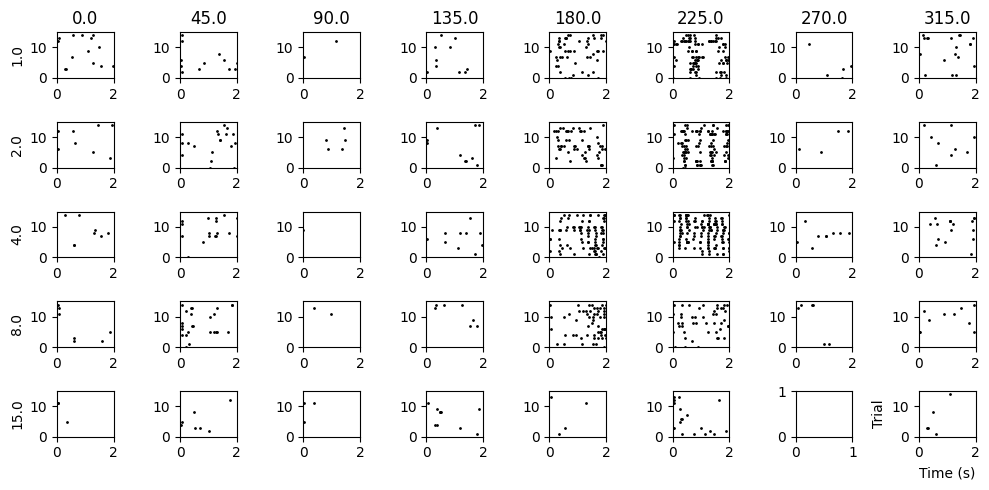

In [77]:
plt.figure(figsize=(10,5))

for tf_index, tf in enumerate(temporal_frequencies):
    
    for ori_idx, ori in enumerate(orientations):
        
        presentation_ids = stimulus_presentations_dg[
            (stimulus_presentations_dg.temporal_frequency == tf) &
            (stimulus_presentations_dg.orientation == ori)].index.values
        
        df = session.presentationwise_spike_times(presentation_ids, [unit_id])
        
        plt.subplot(len(temporal_frequencies),
                    len(orientations), 
                    ori_idx + tf_index * len(orientations) + 1)
        
        if tf_index == 0:
            plt.title(ori)
            
        if ori_idx == 0:
            plt.ylabel(tf)
        
        if len(df) > 0:
            df['trial_index'] = presentation_ids.searchsorted(df.stimulus_presentation_id.values)
            plt.scatter(df['time_since_stimulus_presentation_onset'], df['trial_index'], s=1, c='k')
            plt.xlim([0, 2]) # each trial is 2 seconds long
            plt.ylim([0,len(presentation_ids)])
            
        if ori_idx == 7 and tf_index == 4:
            plt.xlabel('Time (s)')
            plt.ylabel('Trial')
            
plt.tight_layout()

We can very clearly see this unit's preferred orientation is 225 degrees, and it tends to fire more at lower temporal frequencies.

These raster plots display rich information about a unit's dynamics within a trial. For example, you can see that this unit tends to lock it's firing to a specific phase of the drifting grating at its preferred orientation, which is common for cells in V1.

However, for the purposes of population decoding, we are going to summarize the response to each presentation as a single number, the "firing rate." We can visualize the relative firing rate for each stimulus condition using a "star" plot. This plot was developed specifically for the Allen Brain Observatory datasets, and can be created using a function built in the AllenSDK.

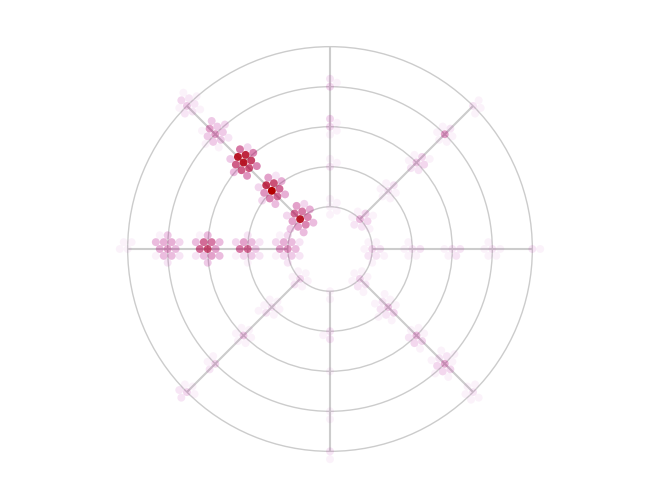

In [78]:
from allensdk.brain_observatory.ecephys.stimulus_analysis.drifting_gratings import DriftingGratings 
dg = DriftingGratings(session)
dg.make_star_plot(unit_id)

Each presentation is summarized as relative color intensity that's proportional to the firing rate. This is the information we will use for population-level decoding.

Note that this approach rests on two very important assumptions:
1. The decoder knows when the stimulus starts and ends
2. All spikes within this window are weighted equally

These are almost certainly not valid when thinking about how downstream brain regions actually decode activity, but they are very useful for understanding what type of information is represented in whatever brain region we're analyzing. This is a very important point: what we ultimately want to know is "how is information contained in neurons' spiking patterns used to guide behavior?" But, without observing the downstream impact of these spikes, we can only ask, "what information can be decoded from neurons' spiking patterns *in principle*?"

## A faster way to extract firing rates

We will now learn about a shortcut for extracting stimulus-evoked spiking activity, which can easily be applied to many units in parallel. Before we do this, we need to take a brief detour to introduce [Xarray](https://docs.xarray.dev/en/stable/), a Python library for manipulating labeled multi-dimensional arrays.

### Introduction to Xarray

An Xarray `DataArray` is basically a wrapper around a `numpy.ndarray` that includes labels for each axis, so this information is always linked to the underlying data. This means you don't need to use separate variables to keep track of the "meaning" of each axis. You can also think of a `DataArray` as a Pandas `DataFrame` with more than two dimensions (not just rows and columns). Each dimension has its own set of indices, just like the rows of a `DataFrame`.

We chose Xarray `DataArray` as one of the return types for the Neuropixels Visual Coding AllenSDK methods, because this format makes it easy to sub-select data, apply operations over particular axes by name, and better understand what an array actually contains.

Let's take a brief tour of how Xarray is used.

In [79]:
import xarray as xr # import the xarray library

unit_ids = np.arange(10) # create IDs for 10 units
time_bins = np.arange(0,1,0.01) # times between 0 and 1 s, in 10 ms intervals

firing_rates = np.random.rand(len(unit_ids), len(time_bins)) # create a matrix of random firing rates

firing_rates.shape #firing rate matrix of 10 units and 100 time bins from 0 to 1s

(10, 100)

We now have a matrix of firing rates for 10 units across 100 10-ms bins. However, the meaning of each value in this matrix cannot be understood without looking at the separate arrays, `unit_ids` and `time_bins`. We can use Xarray to link all of this information together:

In [80]:
da = xr.DataArray(firing_rates, 
                  coords=[unit_ids, time_bins], # coordinates for the matrix
                  dims=["unit_id", "time"]) # dimensions of the matrix

da

<xarray.DataArray (unit_id: 10, time: 100)>
array([[0.53227999, 0.98628906, 0.33626852, 0.60975822, 0.59403613,
        0.62372125, 0.68578177, 0.69137395, 0.02149625, 0.17187938,
        0.5243195 , 0.28483061, 0.28245042, 0.97518236, 0.1538086 ,
        0.94935862, 0.73157949, 0.78881081, 0.9028081 , 0.19625817,
        0.54078324, 0.58429994, 0.04642095, 0.03800585, 0.22891346,
        0.76726077, 0.08895339, 0.51951712, 0.34630438, 0.76106942,
        0.21492732, 0.11623824, 0.8201449 , 0.16168281, 0.84493678,
        0.99725608, 0.53767717, 0.1585113 , 0.90068208, 0.98955219,
        0.1399443 , 0.46332583, 0.24573426, 0.97727713, 0.5270259 ,
        0.40287553, 0.75497767, 0.98275149, 0.77710294, 0.00488749,
        0.51214481, 0.97644509, 0.85752278, 0.34912732, 0.21729956,
        0.05433155, 0.55304294, 0.48006621, 0.55134711, 0.16325142,
        0.84507476, 0.52306298, 0.55035132, 0.40796857, 0.14463728,
        0.46623497, 0.16256057, 0.73737671, 0.79892958, 0.65728053,
        0.60461051, 0.70762372, 0.3197614 , 0.30211913, 0.20303296,
        0.31652856, 0.48253002, 0.245367  , 0.61634607, 0.95636344,
        0.96775969, 0.90705671, 0.57312724, 0.85678655, 0.9153256 ,
        0.90823605, 0.08809049, 0.29006212, 0.78855799, 0.21201319,
        0.20745773, 0.65585498, 0.23931833, 0.7192077 , 0.55120903,
        0.12680885, 0.05749638, 0.2146133 , 0.87255392, 0.4740859 ],
...
       [0.42633178, 0.80742492, 0.22719577, 0.830628  , 0.08539382,
        0.44163342, 0.54073844, 0.68769153, 0.01387247, 0.735004  ,
        0.45062363, 0.33794094, 0.43081615, 0.91156246, 0.2761935 ,
        0.62341514, 0.29043838, 0.11827733, 0.45867621, 0.09246057,
        0.85010513, 0.46356341, 0.02724266, 0.14189889, 0.36301931,
        0.53619561, 0.19595167, 0.58951667, 0.0651711 , 0.46537572,
        0.26578867, 0.45923439, 0.29729106, 0.54395682, 0.36395639,
        0.14847053, 0.42089337, 0.66741595, 0.68797835, 0.87320742,
        0.33597717, 0.85726448, 0.95145135, 0.17324301, 0.27991452,
        0.06702561, 0.48331517, 0.26423282, 0.25243288, 0.55178801,
        0.89455187, 0.0793874 , 0.18381004, 0.59032224, 0.8721918 ,
        0.82747536, 0.77011793, 0.09463078, 0.27612015, 0.77633528,
        0.89913418, 0.96368339, 0.32572966, 0.5544686 , 0.57268687,
        0.48928632, 0.59851719, 0.90687292, 0.25026072, 0.88838206,
        0.40835023, 0.55954105, 0.77687262, 0.06410368, 0.05082308,
        0.15107017, 0.43987544, 0.65194223, 0.23290096, 0.24572857,
        0.80818489, 0.69111266, 0.63184252, 0.76720646, 0.81832254,
        0.89846303, 0.86873597, 0.27834814, 0.93208693, 0.50196979,
        0.12818705, 0.66938469, 0.09645409, 0.52073248, 0.10481631,
        0.57197079, 0.60826334, 0.82419311, 0.00833834, 0.93832865]])
Coordinates:
  * unit_id  (unit_id) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) float64 0.0 0.01 0.02 0.03 0.04 ... 0.95 0.96 0.97 0.98 0.99

We can now use this `DataArray` to refer to axes by name, rather than by index. For example, averaging over the time axis can be done with the following line:

In [81]:
da.mean('time') # average firing rate across time bins for all the units


<xarray.DataArray (unit_id: 10)>
array([0.51369292, 0.46417665, 0.499076  , 0.49987876, 0.48739894,
       0.48341207, 0.52955099, 0.49735086, 0.45867907, 0.48491311])
Coordinates:
  * unit_id  (unit_id) int64 0 1 2 3 4 5 6 7 8 9

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
<b>Task:</b> How would you compute the sum of the firing rates over all units, for each time point?
</div>

In [82]:
# code goes here
da.sum('unit_id') # sum of the firing rates across all the units 


<xarray.DataArray (time: 100)>
array([4.2231405 , 6.4786393 , 3.99488106, 4.12308932, 4.79300186,
       4.90211662, 5.21054008, 4.77687663, 3.96424366, 4.71664745,
       5.06786626, 3.46709077, 4.07742712, 5.83379187, 3.12151741,
       5.43465068, 4.2878688 , 3.95018692, 6.86010426, 3.89899282,
       5.76412065, 5.41301344, 3.29207624, 3.60261963, 5.21882914,
       6.60280704, 4.08449491, 4.61285187, 3.94563927, 4.25932536,
       4.59442658, 5.01748951, 3.71515307, 6.49622714, 5.88714237,
       6.58992988, 4.12174523, 3.49655713, 4.56205758, 7.03678277,
       4.36760291, 5.24663313, 5.77692108, 4.23574422, 3.64445522,
       4.62687584, 5.42669022, 4.65111128, 5.46143222, 4.44157434,
       6.4003043 , 4.13739045, 3.86261227, 4.68918663, 4.70755791,
       4.48081866, 5.18141511, 4.66476   , 4.49166515, 4.67659098,
       5.89179007, 4.80863155, 5.44433158, 5.99985097, 4.83637291,
       4.05651347, 4.94878149, 7.09281268, 5.95595714, 7.19041033,
       5.06922894, 5.92471698, 4.35576738, 3.87913272, 4.12844107,
       4.76210652, 6.07096559, 5.70656967, 5.95099298, 4.49986628,
       5.84864446, 5.39463074, 5.35336327, 6.18903102, 5.0758757 ,
       5.6453812 , 4.84467063, 5.35051415, 6.54540711, 5.22278703,
       3.88767384, 5.76634239, 3.78956272, 3.88797075, 3.04297864,
       4.48001096, 4.32936075, 4.95063488, 3.81249316, 5.15505953])
Coordinates:
  * time     (time) float64 0.0 0.01 0.02 0.03 0.04 ... 0.95 0.96 0.97 0.98 0.99

We can also easily select a subset of data for a few units using Xarray's `sel` method:

In [83]:
da.sel(unit_id=[0,1,2]) # select the first three units


<xarray.DataArray (unit_id: 3, time: 100)>
array([[0.53227999, 0.98628906, 0.33626852, 0.60975822, 0.59403613,
        0.62372125, 0.68578177, 0.69137395, 0.02149625, 0.17187938,
        0.5243195 , 0.28483061, 0.28245042, 0.97518236, 0.1538086 ,
        0.94935862, 0.73157949, 0.78881081, 0.9028081 , 0.19625817,
        0.54078324, 0.58429994, 0.04642095, 0.03800585, 0.22891346,
        0.76726077, 0.08895339, 0.51951712, 0.34630438, 0.76106942,
        0.21492732, 0.11623824, 0.8201449 , 0.16168281, 0.84493678,
        0.99725608, 0.53767717, 0.1585113 , 0.90068208, 0.98955219,
        0.1399443 , 0.46332583, 0.24573426, 0.97727713, 0.5270259 ,
        0.40287553, 0.75497767, 0.98275149, 0.77710294, 0.00488749,
        0.51214481, 0.97644509, 0.85752278, 0.34912732, 0.21729956,
        0.05433155, 0.55304294, 0.48006621, 0.55134711, 0.16325142,
        0.84507476, 0.52306298, 0.55035132, 0.40796857, 0.14463728,
        0.46623497, 0.16256057, 0.73737671, 0.79892958, 0.65728053,
        0.60461051, 0.70762372, 0.3197614 , 0.30211913, 0.20303296,
        0.31652856, 0.48253002, 0.245367  , 0.61634607, 0.95636344,
        0.96775969, 0.90705671, 0.57312724, 0.85678655, 0.9153256 ,
        0.90823605, 0.08809049, 0.29006212, 0.78855799, 0.21201319,
        0.20745773, 0.65585498, 0.23931833, 0.7192077 , 0.55120903,
        0.12680885, 0.05749638, 0.2146133 , 0.87255392, 0.4740859 ],
...
       [0.00635649, 0.95690993, 0.84422691, 0.00507895, 0.52676065,
        0.36036021, 0.95883837, 0.72906476, 0.63432653, 0.79322932,
        0.44902307, 0.04890193, 0.33998924, 0.17613313, 0.29687219,
        0.57790302, 0.16939552, 0.96289304, 0.30988992, 0.16802049,
        0.66792368, 0.29526095, 0.18542613, 0.43570582, 0.84690217,
        0.80867119, 0.71471861, 0.56263713, 0.34622475, 0.37913988,
        0.54840372, 0.0734547 , 0.42223551, 0.86456552, 0.34659832,
        0.37041746, 0.74993589, 0.25600709, 0.18451505, 0.47487264,
        0.96106283, 0.62966803, 0.49527376, 0.8174025 , 0.36131715,
        0.26128755, 0.49419812, 0.64668236, 0.07289305, 0.41354456,
        0.7396658 , 0.49410118, 0.01685546, 0.30686684, 0.36795166,
        0.66385218, 0.10364426, 0.40127436, 0.12984243, 0.8604958 ,
        0.17996466, 0.73745825, 0.64149603, 0.87196087, 0.69215953,
        0.46244758, 0.41243807, 0.95032277, 0.99078551, 0.51326845,
        0.58467006, 0.98648792, 0.05487811, 0.31505239, 0.72369313,
        0.26072204, 0.80172156, 0.44313846, 0.42309142, 0.27876907,
        0.8960397 , 0.56656277, 0.3830784 , 0.58992823, 0.83238184,
        0.13355459, 0.91809592, 0.40444236, 0.4773294 , 0.99314206,
        0.57736702, 0.42288453, 0.28883232, 0.43204268, 0.0779352 ,
        0.73311931, 0.85727429, 0.22163264, 0.39988692, 0.29187403]])
Coordinates:
  * unit_id  (unit_id) int64 0 1 2
  * time     (time) float64 0.0 0.01 0.02 0.03 0.04 ... 0.95 0.96 0.97 0.98 0.99

And if at any time we need access to the underlying NumPy array that holds the data, we can just call `DataArray.data`:

In [84]:
type(da.data) # type of the data in the DataArray object

numpy.ndarray

Hopefully this brief demonstration has convinced you that Xarray offers some useful features for analyzing neural data. For a more in-depth introduction, you can read through the [Xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/index.html).

### Computing trial-wise firing rates for one unit

Getting back to the unit we were analyzing previously, we'd like to compute its firing rate for each presentation at a particular temporal frequency (2 Hz). To do this, we'll use an AllenSDK helper method called `presentationwise_spike_counts`. This one is similar to `presentationwise_spike_counts`, except it returns the data as an `xarray.DataArray` with dimensions of `stimulus_presentation_id`, `time_relative_to_stimulus_onset`, and `unit_id`:

In [86]:
presentations = stimulus_presentations_dg[
            (stimulus_presentations_dg.temporal_frequency == 2.0)] #select the stimulus presentations with a temporal frequency of 2.0 

presentations = presentations.sort_values(by='orientation') #sort the values by orientation 

import warnings  
warnings.filterwarnings("ignore") # ignore warnings for the rest of this tutorial
        
da = session.presentationwise_spike_counts(np.arange(0,1.99,0.01),     # time bins
                                           presentations.index.values, # presentation IDs
                                           [unit_id]                   # unit IDs (in this case just one)
                                          )

da

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 120,
                                  time_relative_to_stimulus_onset: 198,
                                  unit_id: 1)>
array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
...
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3918 .....
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 951103589

To compute the firing rates, we just need to count spikes by summing across the time dimension, and then divide by two (the total number of seconds in each trial):

(120, 1)
(120,)


Text(0.5, 1.0, 'unit 951103589')

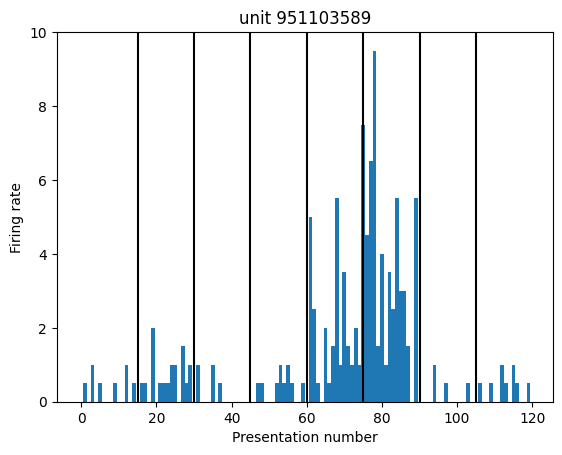

In [87]:
# sum across time dimension
firing_rate_matrix = da.sum('time_relative_to_stimulus_onset') / 2  
print(firing_rate_matrix.shape) 

# call np.squeeze to remove the unused unit_id dimension
firing_rates = np.squeeze(firing_rate_matrix) #squeeze the firing rate matrix to remove the unused unit_id dimension
print(firing_rates.shape)

plt.bar(np.arange(len(presentations)), firing_rates, width=1) #plot the firing rates as a bar plot 

plt.vlines(np.arange(15, len(presentations), 15), 0, 10, 'k') #plot the vertical lines to separate the orientations since we sorted the presentations by orientation 
plt.ylim([0, 10])
plt.xlabel('Presentation number')
plt.ylabel('Firing rate')
plt.title(f'unit {unit_id}')

Since we sorted our `presentations` table by orientation, trials with the same orientation are grouped together.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
<b>Task:</b> Plot the direction tuning curve for this unit by averaging the firing rate over all presentations with the same grating direction.
</div>

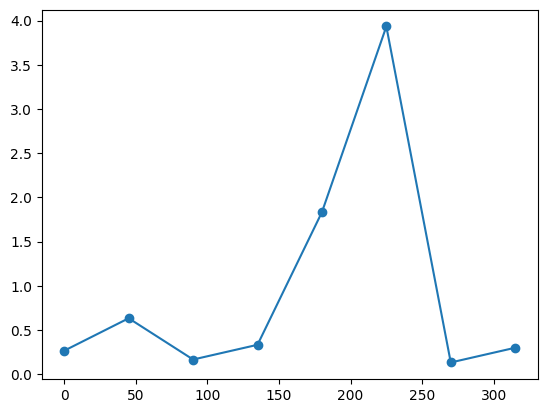

In [90]:
# code goes here

# hint: the first trial for each condition can be found using np.arange(0,len(presentations),15),
# since the trials are already sorted by condition.

mean_rates = [] #create an empty list to store the mean firing rates for each orientation
start_inds = np.arange(0,len(presentations),15) #create an array of the start indices for each orientation

for start_ind in start_inds: #loop through the start indices
    mean_rates.append(firing_rates[start_ind:start_ind+15].mean()) #append the mean firing rate for each orientation to the mean_rates list

plt.plot(orientations, mean_rates, 'o-') #plot the mean firing rates as a function of orientation 

We can further condense the information in the firing rate plot by converting firing rates to colors, similarly to what was done in the star plot above:

In [ ]:
plt.figure(figsize=(10,0.25))

plt.imshow(da.sum('time_relative_to_stimulus_onset').T / 2, cmap='RdPu', aspect='auto')
plt.colorbar(label='Firing rate', aspect=1)

## Extracting the population spiking response

We can now use the `presentationwise_spike_counts` method to retrieve the presentation-aligned activity for all the units in V1, just by changing the last input argument:

In [ ]:
unit_ids = unit_metrics_VISp.sort_values(by=['pref_ori_dg']).index.values

da = session.presentationwise_spike_counts(np.arange(0,1.99,0.01), presentations.index.values, unit_ids)

da

Now, the `unit_id` dimension has 94 entries instead of one, but the other dimensions are identical.

Let's plot the normalized firing rates for all units and all presentations. First, we will compute the maximum firing rate for all trials:

In [ ]:
firing_rates = da.sum('time_relative_to_stimulus_onset').T / 2
max_rates = firing_rates.max('unit_id')

Next, we will use a function called `np.tile` to create a matrix that can be used to normalize each trial's firing rates between 0 and 1:

In [ ]:
max_rates_tiled = np.tile(max_rates, (len(unit_ids),1))

norm_firing_rates = firing_rates / max_rates_tiled 

And finally we can plot this normalized firing rate matrix:

In [ ]:
plt.figure(figsize=(10,8))

plt.imshow(norm_firing_rates, cmap='RdPu', aspect='auto', vmax=1)
plt.xlabel('Presentation index')
plt.ylabel('Unit index')
plt.colorbar(label='Firing rate', aspect=20)
_ = plt.ylim([0, len(unit_ids)])

There are a few things worth noting about this plot:

- Because we sorted the `presentations` table by orientation, the transitions between the orientation conditions are obvious for many units
- A large fraction of units are selective to *orientation* but not *direction*, resulting in similar firing rates for orientations separated by 180 degrees

Just from looking at this data, it seems like it will be possible to extract the stimulus orientation from the firing rates within a given trial (the columns in this matrix). We can select one of these columns using the `DataArray.sel` operator:

In [ ]:
one_trial = norm_firing_rates.sel(stimulus_presentation_id = presentations.index.values[0])

plt.figure(figsize=(0.25,10))

# we need to use "expand_dims" because "imshow" expects a 2D array as input:
plt.imshow(np.expand_dims(one_trial, axis=1), cmap='RdPu', aspect='auto', origin='lower')

This represents the normalized firing rate of all units recorded in V1 for a single trial. Let's format the data in such a way that it's possible to feed it into a `scikit-learn` classifier:

In [ ]:
 # retrieve the underlying numpy array and transpose it
responses = norm_firing_rates.data.T

# we're trying to predict the orientation of each trial
labels = presentations.orientation.values.astype('int')

# the conditions are the unique orientations
conditions = np.unique(labels)

print(f'Shape of response matrix: {responses.shape}')
print(f'Shape of labels matrix: {labels.shape}')

The `responses` matrix contains the normalized firing rates for 120 trials and 94 neurons, and the `labels` matrix contains the orientation for 120 trials. Therefore, each trial is represented as a point in a 94-dimensional space. Our goal is to try and draw boundaries in this space that can be used distinguish between the different grating orientations on randomly held out trials.

## Training a classifier on population spiking data

In order to determine how well we can decode the stimulus direction from population activity, we will train a **classifier** on our matrix of firing rates. Whereas regression models try to predict continuous values from the input features, classification models try to predict *labels* (also known as classes) from the input features.

### Support Vector Machines

Let's start with a linear Support Vector Machine (SVM) classifier, which will try to draw linear boundaries between orientation conditions (the labels) in our 94-dimensional firing rate space.

This cartoon shows how we would expect an SVM to behave on a much simpler dataset, which has two dimensions and three conditions:

![SVM illustration](./resources/svm-classifier.png)

SVM computes decision boundaries in feature space that can be used to classify different conditions. If a new data point appears, the SVM classifier will label it based on where it falls with respect to these boundaries.

To train an SVM, we need to import the following methods from `scikit-learn`:

In [ ]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

We will first select a random subset of trials for training the classifier:

In [ ]:
total_presentations = responses.shape[0]
num_train = int(total_presentations * 0.75) # Use 75% of trials for training
random_trial_order = np.random.permutation(responses.shape[0])
train_indices = random_trial_order[:num_train]

training_data = responses[train_indices]
training_labels = labels[train_indices]

Next, we'll create the model and fit it to our training data:

In [ ]:
clf = svm.SVC(gamma="scale", kernel="linear")
clf.fit(responses[train_indices], labels[train_indices])

Now that our model has been trained, we can ask it to classify unlabeled data (i.e., the sets of population firing rates that were not included in our original training set):

In [ ]:
test_indices = random_trial_order[num_train:]

test_data = responses[test_indices]
predicted_labels = clf.predict(responses[test_indices])

We can compare the predicted labels to the actual labels in order to assess the classifier's performance:

In [ ]:
actual_labels = labels[test_indices]

accuracy = 1 - (np.count_nonzero(predicted_labels - actual_labels) / predicted_labels.size)

plt.figure(figsize=(5,5))

# add a random offset to make sure the points don't overlap
plt.scatter(actual_labels + np.random.rand(len(test_indices)) * 20, 
            predicted_labels + np.random.rand(len(test_indices)) * 20, 
           s=6)
plt.plot([0,360],[0,360],'--k', alpha=0.1)

plt.title(f'Classification accuracy: {accuracy}')
plt.xlabel('Actual direction (degrees)')
plt.xlabel('Predicted direction (degrees)')

Here, we see that most of the trials are predicted correctly (values on the diagonal line), but it's making some mistakes (off-diagonal points). This indicates that the firing rates of our recorded population do contain information about grating direction, but there are some trials in which the direction is ambiguous, at least to this type of classifier.

We can get a better sense of classification performance by using the `scikit-learn.model_selection.KFold` iterator to automatically split up the data into "train" and "test" sets for 5 iterations. Note that the model is fit independently on each iteration.

In [ ]:
accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC(gamma="scale", kernel="linear")
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

Our SVM model performs much better than chance levels, for which we'd expect a classification accuracy of 12.5%.

We can visualize its performance in more detail using a confusion metrix. In the ideal confusion matrix, we would want to have maximum values along the diagonal, and zeros at all other points. Any off-diagonal points that are non-zero show which conditions our classifier is "confusing" with one another.

In [ ]:
def plot_confusion_matrix(confusions):
    
    plt.figure(figsize=(6,6))
    
    mean_confusion = np.mean(confusions, axis=0)

    plt.imshow(mean_confusion)
    plt.colorbar()

    plt.xlabel("actual")
    plt.ylabel("predicted")
    
plot_confusion_matrix(confusions)

When the model makes mistakes, it tends to mis-classify trials by 180 degrees, which is expected given the fact that many units are selective to orientation but not direction.

### Random Forest

To try to avoid some of these errors, we can try a nonlinear classifier (Random Forest) which uses a set of decision trees to determine the label for each trial.

This cartoon shows how a Random Forest behaves on the much simpler case we saw previously:

![Random forest illustration](./resources/random-forest-classifier.png)

Instead of trying to draw explicit boundaries in feature space, this method creates a set of "decision trees" that can be used to classify individual points. In this simple example, only two decisions are needed to classify all points correctly. However, if the feature space is more complicated, these decision trees can grow much larger. To prevent the classification from landing in a local minimum, the Random Forest creates multiple decision trees (hence the name "forest"), and uses majority voting to select the final labels. Random Forest classifiers are highly adaptable, since they make few assumptions about the underlying structure of the data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = RandomForestClassifier()
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

This model appears to be doing even better than the SVM.

In [ ]:
plot_confusion_matrix(confusions)

## Relationship between population size and decoding accuracy

As a final exercise in this tutorial, we'll examine how the size of the simultaneously recorded population affects decoding accuracy. In any physiology experiment, we only have a very small window into the overall population response. For example, there are about 500,000 neurons in mouse V1, so in this case we are measuring around 0.02% of the firing rates in this region.

As the number of simultaneously recorded neurons increases, we expect that our ability to decode stimulus identity will improve. Let's try to get a sense for how this changes with the number of neurons we use to train the classifier:

In [ ]:
total_neurons = np.arange(5, responses.shape[1], 5)

num_iterations = 10
num_splits = 5
accuracies = np.zeros((len(total_neurons), num_iterations, num_splits))

for ind1, N in enumerate(total_neurons):
    
    print(f'total neurons: {N}')
    
    for ind2, iteration in enumerate(range(0,num_iterations)):
        
        random_neuron_order = np.random.permutation(responses.shape[1])
        selected_neurons = random_neuron_order[:N]
        responses_subset = responses[:,selected_neurons]
        
        ind3 = 0

        for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses_subset):

            clf = RandomForestClassifier()
            clf.fit(responses_subset[train_indices], labels[train_indices])

            test_targets = labels[test_indices]
            test_predictions = clf.predict(responses_subset[test_indices])

            accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
            accuracies[ind1, ind2, ind3] = accuracy
            
            ind3 += 1

We can visualize the relationship between neuron count and classification accuracy by averaging over the training splits and iterations:

In [ ]:
plt.plot(total_neurons, np.mean(np.mean(accuracies,2),1))
plt.xlabel('Total neurons')
plt.ylabel('Mean classification accuracy')

Even with only 5 neurons, the random forest classifier still performs above chance (0.125). Performance saturates after around 60 neurons are included in this analysis.

In this tutorial, we learned how to decode drifting grating orientations from population firing rates in V1. Using both a linear (SVM) and nonlinear (Random Forest) classifer, we were able to achieve high levels of decoding accuracy. This only scratches the surface of population-level decoding, and raises a number of follow-up questions that can be pursued as problem sets.

In the next tutorial, we will examine how between-neuron correlations affect decoding.